In [1]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import timm
from timm import optim, scheduler
import torch
from torchvision import transforms as tfm
from sklearn import metrics as skmet
import matplotlib.pyplot as plt
import json
import transforms as my_transforms

%aimport dataset
%aimport models
VideoClassifier = models.VideoClassifier
VideoData = dataset.VideoData

In [3]:
artifact_folder = '/zfs/wficai/pda/model_run_artifacts/20220818_no2d_224x224'

with open(artifact_folder + '/config_video.json', 'r') as f: 
    cfg = json.load(f)

# put all config variables in scope to avoid the need to laboriously index cfg
for k, v in cfg.items():
    v = f"'{v}'" if type(v)==str else v
    exec(f"{k}={v}")
del cfg

In [4]:
# optionally override the view/mode filters
view_filter = ['pdaView', 'pdaRelatedView']
mode_filter = ['color', 'color_compare']

In [5]:
tfms = my_transforms.VideoTransforms(res)
tfms_test = tfms.get_transforms(transforms['test'])

In [6]:
df_test = pd.read_csv(f'{artifact_folder}/{out_paths["test"]}')
d_test = VideoData(df_test, transforms = tfms_test, mode_filter = mode_filter, view_filter = view_filter)
dl_test = DataLoader(d_test, batch_size=bs_test, num_workers=num_workers, collate_fn = VideoData.collate)

print("Number of frames after filtering:", len(d_test.data))

Number of frames after filtering: 10949


In [7]:
# create frame model
m_frames = timm.create_model(model, num_classes=num_classes, in_chans=3, drop_rate=dropout)
_ = m_frames.to(device)

# create video model
m = VideoClassifier(m_frames)

# load checkpoint
m.load_state_dict(torch.load(f"{artifact_folder}/model_checkpoint_video.ckpt"))

<All keys matched successfully>

In [19]:
loss_function = torch.functional.F.binary_cross_entropy_with_logits

target_ls = []
output_ls = []
study_ls = []
mask_ls = []
externalid_ls = []
view_ls = []
mode_ls = []
losses = []
attn_ls = []


for ix, batch in enumerate(dl_test):
    print(f"Batch {ix+1}", end = "\r")
    vid = batch['video'].to(device)
    mask = batch['mask'].to(device)
    targets = batch['trg_type'].to(device).type(torch.float32)
    
    target_ls.append(targets.cpu().numpy())
    view_ls.append(batch['trg_view'].numpy())
    mode_ls.append(batch['trg_mode'].numpy())
    study_ls += batch['study']
    mask_ls.append(batch['mask'].numpy())
    externalid_ls += batch['external_id']

    with torch.no_grad():
        outputs, attn = m(vid, mask)
        output_ls.append(outputs.cpu().numpy())
        attn_ls.append(attn.cpu().numpy())
        loss = loss_function(outputs.squeeze(), targets)
        losses.append(loss.detach().item())

In [21]:
df_results = pd.DataFrame(dict(
    study = study_ls,
    external_id = externalid_ls,
    predicted = np.concatenate(output_ls).squeeze(),
    target = np.concatenate(target_ls), 
    mode = np.concatenate(mode_ls),
    view = np.concatenate(view_ls)
))

df_results['mode'] = df_results['mode'].map(VideoData.inv_mode_map)
df_results.view = df_results.view.map(VideoData.inv_view_map)

df_results.head(20)

,study,external_id,predicted,target,mode,view
0,study11,study11_dicom36,0.170503,0.0,color_compare,pdaView
1,study11,study11_dicom49,0.314752,0.0,color_compare,pdaView
2,study21,study21_dicom45,0.052819,0.0,color,pdaRelatedView
3,study21,study21_dicom28,0.061510,0.0,color,pdaRelatedView
4,study3,study3_dicom51,0.141463,0.0,color,pdaRelatedView
5,study3,study3_dicom47,0.481277,0.0,color,pdaRelatedView
6,study43,study43_dicom14,0.030506,0.0,color_compare,pdaRelatedView
7,study43,study43_dicom24,0.212562,0.0,color_compare,pdaView
8,study5,study5_dicom34,0.068687,0.0,color,pdaRelatedView
9,study54,study54_dicom10,0.038847,0.0,color,pdaRelatedView


In [22]:
def compute_metrics(y_true, y_pred, thresh=0.5):
    mets = dict()
    
    y_pred_cls = (y_pred>thresh).astype(int)
    
    mets['num_samples'] = len(y_true)
    mets['roc_auc'] = skmet.roc_auc_score(y_true, y_pred)
    mets['average_precision'] = skmet.average_precision_score(y_true, y_pred)
    mets['accuracy'] = skmet.accuracy_score(y_true, y_pred_cls)
    mets['sensitivity'] = skmet.recall_score(y_true, y_pred_cls)
    mets['specificity'] = skmet.recall_score(y_true, y_pred_cls, pos_label=0)
    
    return mets

# Clip-level results

In [23]:
compute_metrics(df_results.target, df_results.predicted)

{'num_samples': 123,
 'roc_auc': 0.9404302261445119,
 'average_precision': 0.9376749458801884,
 'accuracy': 0.9024390243902439,
 'sensitivity': 0.8367346938775511,
 'specificity': 0.9459459459459459}

In [24]:
grouped_results = df_results.groupby(['view', 'mode']).apply(lambda dat: compute_metrics(dat.target, dat.predicted))
grouped_results = pd.DataFrame(grouped_results.tolist(), index=grouped_results.index)
grouped_results

num_samples   roc_auc  average_precision  \
view           mode                                                      
pdaRelatedView color                   39  0.968966           0.937500   
               color_compare           33  0.796992           0.776757   
pdaView        color                   19  1.000000           1.000000   
               color_compare           32  0.984314           0.988796   

                              accuracy  sensitivity  specificity  
view           mode                                               
pdaRelatedView color          0.948718     0.800000     1.000000  
               color_compare  0.757576     0.642857     0.842105  
pdaView        color          1.000000     1.000000     1.000000  
               color_compare  0.937500     0.941176     0.933333

# Attention

In [96]:
df_results.query('target==1.0')

,study,external_id,predicted,target,mode,view
22,study2,study2_dicom9,0.999960,1.0,color_compare,pdaView
23,study2,study2_dicom12,0.999165,1.0,color_compare,pdaView
24,study2,study2_dicom13,0.999770,1.0,color_compare,pdaView
25,study2,study2_dicom17,0.273674,1.0,color,pdaRelatedView
26,study2,study2_dicom41,0.416963,1.0,color,pdaRelatedView
47,study20,study20_dicom88,0.020377,1.0,color_compare,pdaRelatedView
48,study20,study20_dicom94,0.725355,1.0,color_compare,pdaView
49,study20,study20_dicom95,0.994417,1.0,color_compare,pdaView
50,study20,study20_dicom98,0.500720,1.0,color_compare,pdaRelatedView
51,study20,study20_dicom99,0.290202,1.0,color_compare,pdaRelatedView


In [97]:
index = 86
batch_ix = index // bs_test
ix_in_batch = index % bs_test

mask = mask_ls[batch_ix][...,ix_in_batch]
attn = attn_ls[batch_ix][...,ix_in_batch]
trg_type = int(target_ls[batch_ix][ix_in_batch])
target = VideoData.inv_type_map[trg_type]
view = VideoData.inv_view_map[int(view_ls[batch_ix][ix_in_batch])]
external_id = externalid_ls[index]

mp4_path = df_test.loc[(df_test.external_id == external_id) & (df_test.trg_type == trg_type)].mp4_path.unique().item()
mp4_path = mp4_path.replace('/Superior Views/', '/superior_views_h264/')

print(external_id, target, view, sep=' - ')

study1_dicom11 - pda - pdaView


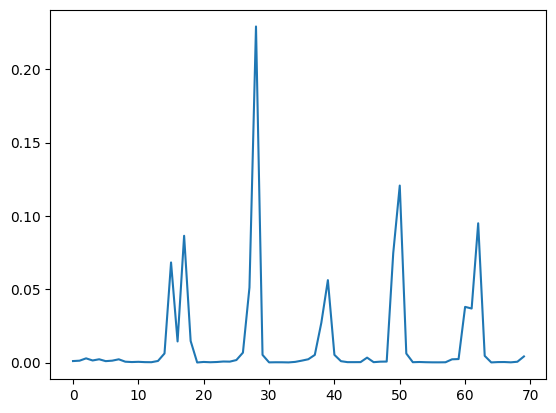

In [98]:
plt.plot(attn[mask])

In [101]:
from IPython.display import FileLink
!cp $mp4_path /home/dane2/Code/pda_detection/